In [5]:

import copy
import numpy as np
import cv2
import random
from scipy.spatial.transform import Rotation as spr
from matplotlib import pyplot as plt
import sksurgerycore.algorithms.procrustes as pro
import sksurgerycore.transforms.matrix as mu


In [20]:
# ALL MEASUREMENTS IN MM

# P - length from tip of pointer to reference of pointer
pointer_length = 100

# D - z distance from camera to plane where everything is located
distance_from_cam = 1000 # since the camera and patient reference are aligned in the x and y directions, only distance is in z

# 0 - angle of pointer
pointer_angle = 45

# Yc - distances from cancer to patient reference
cancer_patref_y = 50  

# NDI quotes 0.25mm for Polaris Spectra, some papers estimate it at 0.17mm
typical_tracking_sigma = 0.25

# For Model 2 and 3, using an endoscope, this determines the distance of a target of interest from the endoscope.
working_distance = 50

# For Model 2 and 3, the length of the endoscope.
length_of_endoscope = 100 # use 300 after merging


In [21]:
from end_utils import create_transform, \
                                  multiply_points_by_matrix, \
                                  multiply_point_by_matrix, pointer_to_mri,\
                                  camera_to_mri, mri_to_camera, add_noise_to_points,\
                                  add_noise_to_params, extract_rigid_body_parameters,\
                                  rigid_body_parameters_to_matrix, \
                                  convert_4x1_to_1x1x3, project_camera_point_to_image, \
                                  create_pnt_ref, create_pnt_ref_in_camera_space, create_pat_ref, \
                                  create_pat_ref_in_camera_space, get_ref_T_tip, calculate_euclid_dist



# Simulation 2: Accuracy of AR using tracked endoscope

In Model 1, we studied the accuracy of measuring a point in 3D space, using a tracked pointer, and converting that to a point in the MR/CT scan, via registration.

In Model 2, we want to study the accuracy of a tracked endoscope, and what the expected accuracy of an overlay will be. The overlay accuracy, could be measured in terms of accuracy in 3D in the endoscope camera frame, or in terms of 2D pixel accuracy.

In order to make this a like-for-like comparison, we should keep most of the reference data identical. The difference now, is we swap a pointer for a laparoscope. We will need an additional hand-eye calibration, and reference data to project from camera space onto image space, but we leave all other data the same. 

![endoscope](./images/endoscope_setup.png)


## EndP to EndRef

We start by getting the transform between the endoscope's tip to the reference.

[[  0.   0.   0.   1.]
 [  0.   0.  50.   1.]
 [  0.  25. 100.   1.]
 [  0. -25. 135.   1.]]


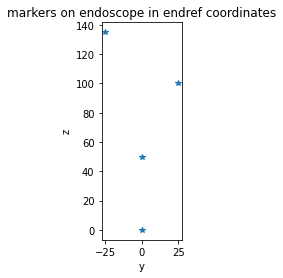

In [22]:
# Creating pointer reference (from datasheet). Using homogenous (4 numbers, x,y,z,1) as row vectors.
end_ref =  create_pnt_ref()
print(end_ref)

# Plotting original points, to check it looks ok.
plt.figure()
plt.plot(end_ref[:,1],end_ref[:,2], marker='*',linestyle = 'None',)
plt.title('markers on endoscope in endref coordinates')
plt.xlabel('y')
plt.ylabel('z')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

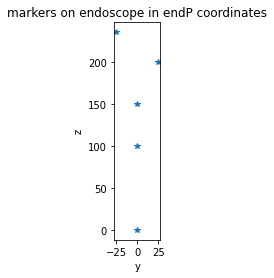

In [23]:
# Here we offset the points by the length of the pointer to make the origin the endoscope's tip
offset_marker_transform = get_ref_T_tip(length_of_endoscope, 'z') # create transform of all points depending on pointer's length
end_ref_transformed = multiply_points_by_matrix(offset_marker_transform, end_ref, do_transpose=True) # transform all pointer points by this reference
end_ref_with_tip = np.concatenate((end_ref_transformed, [[0, 0, 0, 1]]), axis=0) # adding tip to points


# Plotting trabsformed points
plt.figure()
plt.plot(end_ref_with_tip[:,1],end_ref_with_tip[:,2], marker='*',linestyle = 'None',)
plt.title('markers on endoscope in endP coordinates')
plt.xlabel('y')
plt.ylabel('z')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


## EndRef to Cam

end_ref_in_camera_space_at_patient=
[[  70.71067812   70.71067812 1000.            1.        ]
 [ 106.06601718  106.06601718 1000.            1.        ]
 [ 123.74368671  159.09902577 1000.            1.        ]
 [ 183.84776311  148.49242405 1000.            1.        ]
 [   0.            0.         1000.            1.        ]]


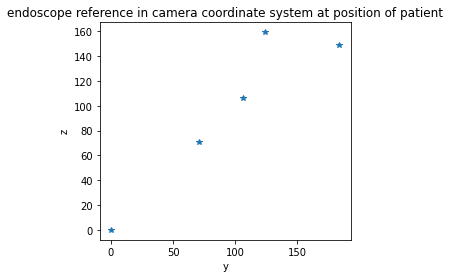

In [24]:
end_ref_in_camera_space =  create_pnt_ref_in_camera_space()

offset_marker_transform_cam = create_transform([pointer_length, 0, 0, 0, 0, 0])
end_ref_in_camera_space_transformed = multiply_points_by_matrix(offset_marker_transform_cam, end_ref_in_camera_space, do_transpose=True)
end_ref_in_camera_space_with_tip = np.concatenate((end_ref_in_camera_space_transformed, [[0, 0, 0, 1]]), axis=0)

# Now we want to rotate around z (according to diagram above), then translate to a distance from camera.
rotate_about_z = create_transform([0, 0, 0, 0, 0, pointer_angle]) 
translate_away_from_camera = create_transform([0, 0, distance_from_cam, 0, 0, 0])
end_ref_in_camera_space_at_patient = multiply_points_by_matrix(translate_away_from_camera @ rotate_about_z, end_ref_in_camera_space_with_tip, do_transpose=True)
print("end_ref_in_camera_space_at_patient=\n" + str(end_ref_in_camera_space_at_patient))


# Plotting trabsformed points
plt.figure()
plt.plot(end_ref_in_camera_space_at_patient[:,0],end_ref_in_camera_space_at_patient[:,1], marker='*',linestyle = 'None',)
plt.title('endoscope reference in camera coordinate system at position of patient')
plt.xlabel('y')
plt.ylabel('z')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [25]:
endoscope_markers_in_camera_space = end_ref_in_camera_space_at_patient[0:4,0:3]
########## NOTE- IS THIS CORRECT? WOUDN'T IT JUST BE end_Ref? If it's in marker space the 0,0 should be in marker A?
endoscope_markers_in_marker_space = end_ref_with_tip[0:4,0:3]

print("endoscope_markers_in_camera_space=\n" + str(endoscope_markers_in_camera_space))
print("endoscope_markers_in_marker_space=\n" + str(endoscope_markers_in_marker_space))


endoscope_markers_in_camera_space=
[[  70.71067812   70.71067812 1000.        ]
 [ 106.06601718  106.06601718 1000.        ]
 [ 123.74368671  159.09902577 1000.        ]
 [ 183.84776311  148.49242405 1000.        ]]
endoscope_markers_in_marker_space=
[[  0.   0. 100.]
 [  0.   0. 150.]
 [  0.  25. 200.]
 [  0. -25. 235.]]


Calculating transform between endoscope's marker space to camera space

In [26]:
# getting transformation between coordinate systems
Cam_T_EndRef_r, Cam_T_EndRef_t, Cam_T_Endo_FRE = pro.orthogonal_procrustes(endoscope_markers_in_camera_space, endoscope_markers_in_marker_space)
print("Cam_T_EndRef_r=\n" + str(Cam_T_EndRef_r))
print("Cam_T_EndRef_t=\n" + str(Cam_T_EndRef_t))
print("Cam_T_Endo_FRE=\n" + str(Cam_T_Endo_FRE))
# reconstructing translation and rotation to one matrix
Cam_T_EndRef = mu.construct_rigid_transformation(Cam_T_EndRef_r, Cam_T_EndRef_t)
print("Cam_T_EndRef=\n" + str(Cam_T_EndRef))



Cam_T_EndRef_r=
[[ 1.59218830e-16 -7.07106781e-01  7.07106781e-01]
 [-1.92482452e-16  7.07106781e-01  7.07106781e-01]
 [-1.00000000e+00 -2.77555756e-16  0.00000000e+00]]
Cam_T_EndRef_t=
[[2.84217094e-14]
 [0.00000000e+00]
 [1.00000000e+03]]
Cam_T_Endo_FRE=
1.2306961192854808e-14
Cam_T_EndRef=
[[ 1.59218830e-16 -7.07106781e-01  7.07106781e-01  2.84217094e-14]
 [-1.92482452e-16  7.07106781e-01  7.07106781e-01  0.00000000e+00]
 [-1.00000000e+00 -2.77555756e-16  0.00000000e+00  1.00000000e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


## Patient reference tracking (PatRef to Cam)

In [27]:
# Encoding the reference marker points into a numpy matrix
pat_ref = create_pat_ref()

In [28]:
pat_ref_in_camera_space = create_pat_ref_in_camera_space()

# Now put it in the right place (away from patient as in pointer simulation)
translate_along_negative_y = create_transform([0, -cancer_patref_y, 0, 0, 0, 0])
pat_ref_in_camera_space_at_patient = multiply_points_by_matrix(translate_along_negative_y @ translate_away_from_camera, pat_ref_in_camera_space, do_transpose=True)


[[  0.     0.     0.     0.  ]
 [  0.    41.02  28.59   0.  ]
 [  0.    88.     0.     0.  ]
 [  0.    40.45 -44.32   0.  ]]


In [29]:

# As above, compute the tracking transformation.
Cam_T_PatRef_r, Cam_T_PatRef_t, Cam_T_PatRef_FRE = pro.orthogonal_procrustes(pat_ref_in_camera_space_at_patient[:,0:3], pat_ref[:,0:3])


# Also, construct a 4x4 tracking transformation. It should look like a translation, with no rotation.
Cam_T_PatRef = mu.construct_rigid_transformation(Cam_T_PatRef_r, Cam_T_PatRef_t)


## PatRef to MRI

As with the pointer simulation, we apply a known translation

In [30]:
# Average head dimensions from: https://en.wikipedia.org/wiki/Human_head

x_t = 100 # head length (about 20cm)
y_t = 130 # menton to top of head (about 25cm)
z_t = 80 # head bredth (about 15cm)

PatRef_T_MRI = create_transform([-x_t, -y_t, -z_t, 0, 0, 0])
print("Cam_T_PntRef=\n" + str(PatRef_T_MRI))

Cam_T_PntRef=
[[   1.    0.    0. -100.]
 [   0.    1.    0. -130.]
 [   0.    0.    1.  -80.]
 [   0.    0.    0.    1.]]


In [31]:
# These are the baseline parameters for the MRI registration (whether thats PBR or SBR)
PatRef_T_MRI_parameters = extract_rigid_body_parameters(PatRef_T_MRI)
print("PatRef_T_MRI=\n" + str(PatRef_T_MRI))
print("PatRef_T_MRI_parameters=" + str(PatRef_T_MRI_parameters))

PatRef_T_MRI=
[[   1.    0.    0. -100.]
 [   0.    1.    0. -130.]
 [   0.    0.    1.  -80.]
 [   0.    0.    0.    1.]]
PatRef_T_MRI_parameters=[0.0, 0.0, 0.0, -100.0, -130.0, -80.0]


## Summary of some details

In [35]:
# Endoscope ref tracking
print("endoscope_markers_in_camera_space=\n" + str(endoscope_markers_in_camera_space))
print("endoscope_markers_in_marker_space=\n" + str(endoscope_markers_in_marker_space))

print('\n')
print("Cam_T_EndRef_r=\n" + str(Cam_T_EndRef_r))
print("Cam_T_EndRef_t=\n" + str(Cam_T_EndRef_t))
print("Cam_T_Endo_FRE=\n" + str(Cam_T_Endo_FRE))
print("Cam_T_EndRef=\n" + str(Cam_T_EndRef))




# Patient ref tracking
print('\n')
print("Patient ref model=\n" + str(pat_ref))
print("Patient ref model in camera space=\n" + str(pat_ref_in_camera_space_at_patient))
print("Cam_T_PatRef_r=\n" + str(Cam_T_PatRef_r))
print("Cam_T_PatRef_t=\n" + str(Cam_T_PatRef_t))
print("Cam_T_PatRef_FRE=\n" + str(Cam_T_PatRef_FRE))
print("Cam_T_PatRef=\n" + str(Cam_T_PatRef))

# MRI to PatRef transform and parameters
print('\n')
print("PatRef_T_MRI=\n" + str(PatRef_T_MRI))
print("PatRef_T_MRI_parameters=" + str(PatRef_T_MRI_parameters))


endoscope_markers_in_camera_space=
[[  70.71067812   70.71067812 1000.        ]
 [ 106.06601718  106.06601718 1000.        ]
 [ 123.74368671  159.09902577 1000.        ]
 [ 183.84776311  148.49242405 1000.        ]]
endoscope_markers_in_marker_space=
[[  0.   0. 100.]
 [  0.   0. 150.]
 [  0.  25. 200.]
 [  0. -25. 235.]]


Cam_T_EndRef_r=
[[ 1.59218830e-16 -7.07106781e-01  7.07106781e-01]
 [-1.92482452e-16  7.07106781e-01  7.07106781e-01]
 [-1.00000000e+00 -2.77555756e-16  0.00000000e+00]]
Cam_T_EndRef_t=
[[2.84217094e-14]
 [0.00000000e+00]
 [1.00000000e+03]]
Cam_T_Endo_FRE=
1.2306961192854808e-14
Cam_T_EndRef=
[[ 1.59218830e-16 -7.07106781e-01  7.07106781e-01  2.84217094e-14]
 [-1.92482452e-16  7.07106781e-01  7.07106781e-01  0.00000000e+00]
 [-1.00000000e+00 -2.77555756e-16  0.00000000e+00  1.00000000e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


Patient ref model=
[[  0.     0.     0.     1.  ]
 [  0.    28.59  41.02   1.  ]
 [  0.     0.    88.     1. 

## Laparoscope specific parameters

Previously the length of the pointer was specified in the variable: pointer_length, typically about 100mm.

(To Do, actually measure the medtronic one).

We need a function to create a hand-eye transformation, between the tracking marker on the laparoscope, and the camera coordinate system.

In [46]:
# NOTE TO MENTION- ISN'T THIS THE SAME AS OFFSET FUNCTION?
def create_hand_eye(length_of_endoscope):
    transform = np.eye(4)
    transform[2][3] = -(pointer_length - length_of_endoscope)
    return transform

### Check hand-eye is working

If you look at the above coordinates in the variable endoscope_markers_in_marker_space

In [47]:
print(endoscope_markers_in_marker_space)

[[  0.   0. 100.]
 [  0.   0. 150.]
 [  0.  25. 200.]
 [  0. -25. 235.]]


The tracking ball nearest the tip has a +ve z coordinate of 100 ((((to double check with matt)))))). 

If we move towards the pointer/laparoscope tip, you'd expect the z-coordinate to decrease. 

Furthermore, if we imagine that the laparoscope is 30cm/300mm long, then a point that is 300mm from the tracking ball would have z-coordinate -200. 

So, if we multiple [0, 0, -200] by hand-eye (i.e. the marker-to-camera transformation, we would expect the [0, 0, -200] to be mapped to [0, 0, 0], i.e the centre of projection of the laparoscope. 

In [61]:
length_of_endoscope = 300

cop_in_laparascope_marker_space=np.zeros((4,1))
cop_in_laparascope_marker_space[2][0] = -200
cop_in_laparascope_marker_space[3][0] = 1
print("Input=" + str(cop_in_laparascope_marker_space))

hand_eye = create_hand_eye(length_of_endoscope)
print("Transform=" + str(hand_eye))

cop_in_camera_space = multiply_point_by_matrix(hand_eye, cop_in_laparascope_marker_space)
print("Output=" + str(cop_in_camera_space))


Input=[[   0.]
 [   0.]
 [-200.]
 [   1.]]
Transform=[[  1.   0.   0.   0.]
 [  0.   1.   0.   0.]
 [  0.   0.   1. 200.]
 [  0.   0.   0.   1.]]
Output=[[0.]
 [0.]
 [0.]
 [1.]]


## Target Point in Camera and MRI space- come back to this

Imagine that the working distance of the endoscope is about 5cm? (ToDo, check this for something realistic). Then we need to know the location of the target point in camera, and world space.

In [62]:
target_location_in_camera_space = np.zeros((4,1))
target_location_in_camera_space[2][0] = working_distance
target_location_in_camera_space[3][0] = 1

target_location_in_mri_space = camera_to_mri(Cam_T_EndRef, Cam_T_PatRef, PatRef_T_MRI, hand_eye, target_location_in_camera_space)

print("Target in camera space=" + str(target_location_in_camera_space))
print("Target in MRI space=" + str(target_location_in_mri_space))

Target in camera space=[[ 0.]
 [ 0.]
 [50.]
 [ 1.]]
Target in MRI space=[[206.06601718]
 [130.        ]
 [ 23.93398282]
 [  1.        ]]


We now have a laparoscope system set up. Let's simulate what the effect of tracker noise is on 3D and 2D overlay accuracy, and also registration errors (mm/degrees), on both 3D and 2D overlay accuracy. 

# Simulation 1: Effect of Tracker Noise on Endoscope System

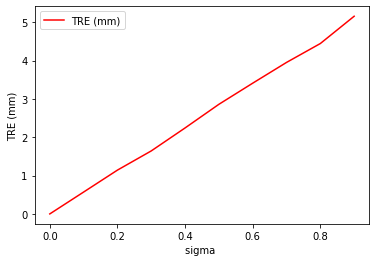

In [64]:
number_samples = 1000
x_values = []
y_values = []
for sigma_counter in range(0, 10, 1):
    sigma = float(sigma_counter) / float(10)
    rms = 0
    for i in range(number_samples):
        
        # Here we add tracking noise to the endoscope and reference.
        tmp_endoscope = add_noise_to_points(endoscope_markers_in_camera_space, sigma) # Mustn't include pointer tip! 
        tmp_ref = add_noise_to_points(pat_ref_in_camera_space_at_patient[:,0:3], sigma)

        R, t, FRE = pro.orthogonal_procrustes(tmp_endoscope, endoscope_markers_in_marker_space)
        tmp_endoscope_to_cam = mu.construct_rigid_transformation(R, t)
        
        R, t, FRE = pro.orthogonal_procrustes(tmp_ref, pat_ref[0:4, 0:3])
        tmp_reference_to_cam = mu.construct_rigid_transformation(R, t)
        
        transformed_point = camera_to_mri(tmp_endoscope_to_cam, tmp_reference_to_cam, PatRef_T_MRI, hand_eye, target_location_in_camera_space)
        euclid_dist = calculate_euclid_dist(transformed_point, target_location_in_mri_space)
        
        rms = rms + euclid_dist
    rms = rms / float(number_samples)
    rms = np.sqrt(rms)
    x_values.append(sigma)
    y_values.append(rms)
    
plt.plot(x_values, y_values, 'r', label='TRE (mm)')
plt.legend(loc='upper left')
plt.xlabel('sigma ')
plt.ylabel('TRE (mm)')
plt.show()
        

# Simulation 2: Tracking error + Registration error for Endoscope System

As above, we'd like to simulate the effects of registration error, as well as tracking error.

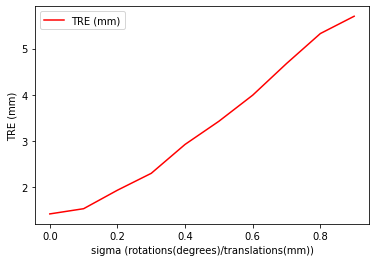

In [65]:
number_samples = 1000
x_values = []
y_values = []
for sigma_counter in range(0, 10, 1):
    sigma = float(sigma_counter) / float(10)
    rms = 0
    for i in range(number_samples):
        
        # Here we add tracking noise to the pointer and reference.
        tmp_endoscope = add_noise_to_points(endoscope_markers_in_camera_space, typical_tracking_sigma) # Mustn't include pointer tip! 
        tmp_ref = add_noise_to_points(pat_ref_in_camera_space_at_patient[:,0:3], typical_tracking_sigma)
        
        # Here we add noise onto the PatRef_T_MRI_parameters, and reconstruct a new registration
        tmp_params = add_noise_to_params(PatRef_T_MRI_parameters, sigma)
        tmp_mri_to_patref = rigid_body_parameters_to_matrix(tmp_params)
        
        R, t, FRE = pro.orthogonal_procrustes(tmp_endoscope, endoscope_markers_in_marker_space)
        tmp_endoscope_to_cam = mu.construct_rigid_transformation(R, t)
        
        R, t, FRE = pro.orthogonal_procrustes(tmp_ref, pat_ref[0:4, 0:3])
        tmp_reference_to_cam = mu.construct_rigid_transformation(R, t)
        
        transformed_point = camera_to_mri(tmp_endoscope_to_cam, tmp_reference_to_cam, tmp_mri_to_patref, hand_eye, target_location_in_camera_space)
        
        euclid_dist =  calculate_euclid_dist(transformed_point, target_location_in_mri_space)
        
        rms = rms + euclid_dist
    rms = rms / float(number_samples)
    rms = np.sqrt(rms)
    x_values.append(sigma)
    y_values.append(rms)
    
plt.plot(x_values, y_values, 'r', label='TRE (mm)')
plt.legend(loc='upper left')
plt.xlabel('sigma (rotations(degrees)/translations(mm))')
plt.ylabel('TRE (mm)')
plt.show()
     

# Simulation 3: Effect of Hand-Eye and Tracking Error in Endoscope System

In addition to above, what if we vary hand-eye, is this better/worse, meaning less/more important to get right than the registration?

Matt: The problem with this experiment, is we don't yet know how variable a typical hand-eye calibration is. Imagine the scenario where 10 different members of staff, did 10 different calibrations, and we looked at the standard-deviation (sigma) of the rotation parameters, and translation parameters. Would they be within the range of sigma of 0-1? If they are much worse, then the numbers below will need adjusting.

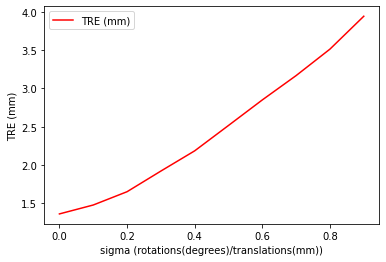

In [66]:
Hand_T_Eye_parameters = extract_rigid_body_parameters(hand_eye)

number_samples = 1000
x_values = []
y_values = []
for sigma_counter in range(0, 10, 1):
    sigma = float(sigma_counter) / float(10)
    rms = 0
    for i in range(number_samples):
        
        # Here we add tracking noise to the pointer and reference.
        tmp_endoscope = add_noise_to_points(endoscope_markers_in_camera_space, typical_tracking_sigma) # Mustn't include pointer tip! 
        tmp_ref = add_noise_to_points(pat_ref_in_camera_space_at_patient[:,0:3], typical_tracking_sigma)
        
        # Here we add noise onto the PatRef_T_MRI_parameters, and reconstruct a new registration
        tmp_hand_eye_params = add_noise_to_params(Hand_T_Eye_parameters, sigma)
        tmp_hand_eye = rigid_body_parameters_to_matrix(tmp_hand_eye_params)
        
        R, t, FRE = pro.orthogonal_procrustes(tmp_endoscope, endoscope_markers_in_marker_space)
        tmp_endoscope_to_cam = mu.construct_rigid_transformation(R, t)
        
        R, t, FRE = pro.orthogonal_procrustes(tmp_ref, pat_ref[0:4, 0:3])
        tmp_reference_to_cam = mu.construct_rigid_transformation(R, t)
        
        transformed_point = camera_to_mri(tmp_endoscope_to_cam, tmp_reference_to_cam, PatRef_T_MRI, tmp_hand_eye, target_location_in_camera_space)
        
        euclid_dist = calculate_euclid_dist(transformed_point, target_location_in_mri_space)
        
        rms = rms + euclid_dist
    rms = rms / float(number_samples)
    rms = np.sqrt(rms)
    x_values.append(sigma)
    y_values.append(rms)
    
plt.plot(x_values, y_values, 'r', label='TRE (mm)')
plt.legend(loc='upper left')
plt.xlabel('sigma (rotations(degrees)/translations(mm))')
plt.ylabel('TRE (mm)')
plt.show()
     

# Simulation 4: In AR How Many Pixels Off?

The above simulations simply measure the true 3D distance in MRI space. So, given tracking errors, and either hand-eye or registration errors, how far off would we be if we mapped back to MRI space. (Similarly we could run the application the other way round, and express this in camera space, but the error would be the same).

But, given that the field of view is so, small, how many pixels would this amount to? Most endoscopes run on 1920x1080p Full HD, on a reasonable monitor. So, how many pixels off are we?

In the simulation below, we will assume we are dealing with a perfect hand-eye calibration, and repeat the experiment that investigated errors in registration, but this time, projecting to the image coordinates, and measuring the distance in pixels. If subsequent lab experiments show that hand-eye is more critical, then the experiment below can be repeated, but varying the hand-eye instead of the registration.

In [67]:
# Camera calibration
intrinsics = np.loadtxt('calibration/intrinsics.txt')
distortion = np.loadtxt('calibration/distortion.txt')

print("Intrinsics are:" + str(intrinsics))
print("Distortion coefficients are:" + str(distortion))

# Need to project target point to image plane. Incidentally, the target point 
# was straight along the optical axis, so should project to the middle of the image.
target_location_in_image_coordinates = project_camera_point_to_image(target_location_in_camera_space, intrinsics, distortion)
print("target_location_in_image_coordinates=" + str(target_location_in_image_coordinates))

Intrinsics are:[[664.6329766    0.         931.53151205]
 [  0.         663.83211807 520.64004697]
 [  0.           0.           1.        ]]
Distortion coefficients are:[-4.0929449e-01  2.1631278e-01  1.1120000e-05  1.2712000e-03
 -7.2057120e-02]
target_location_in_image_coordinates=[931.53151205 520.64004697]


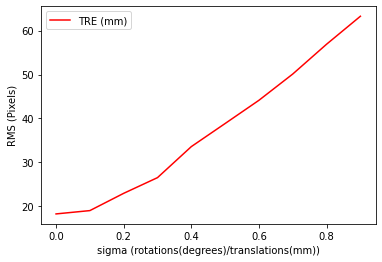

In [69]:
number_samples = 1000
x_values = []
y_values = []
for sigma_counter in range(0, 10, 1):
    sigma = float(sigma_counter) / float(10)
    rms = 0
    for i in range(number_samples):
        
        # Here we add tracking noise to the pointer and reference.
        tmp_endoscope = add_noise_to_points(endoscope_markers_in_camera_space, typical_tracking_sigma) # Mustn't include pointer tip! 
        tmp_ref = add_noise_to_points(pat_ref_in_camera_space_at_patient[:,0:3], typical_tracking_sigma)
        
        # Here we add noise onto the PatRef_T_MRI_parameters, and reconstruct a new registration
        tmp_params = add_noise_to_params(PatRef_T_MRI_parameters, sigma)
        tmp_mri_to_patref = rigid_body_parameters_to_matrix(tmp_params)
        
        R, t, FRE = pro.orthogonal_procrustes(tmp_endoscope, endoscope_markers_in_marker_space)
        tmp_endoscope_to_cam = mu.construct_rigid_transformation(R, t)
        
        R, t, FRE = pro.orthogonal_procrustes(tmp_ref, pat_ref[0:4, 0:3])
        tmp_reference_to_cam = mu.construct_rigid_transformation(R, t)
        
        transformed_point_in_camera_space = mri_to_camera(tmp_endoscope_to_cam, tmp_reference_to_cam, tmp_mri_to_patref, hand_eye, target_location_in_mri_space)
        transformed_point_in_image_space = project_camera_point_to_image(transformed_point_in_camera_space, intrinsics, distortion)
        
        euclid_dist =  (transformed_point_in_image_space[0] - target_location_in_image_coordinates[0]) \
                     * (transformed_point_in_image_space[0] - target_location_in_image_coordinates[0]) \
                     + (transformed_point_in_image_space[1] - target_location_in_image_coordinates[1]) \
                     * (transformed_point_in_image_space[1] - target_location_in_image_coordinates[1]) 
        
        rms = rms + euclid_dist
    rms = rms / float(number_samples)
    rms = np.sqrt(rms)
    x_values.append(sigma)
    y_values.append(rms)
    
plt.plot(x_values, y_values, 'r', label='TRE (mm)')
plt.legend(loc='upper left')
plt.xlabel('sigma (rotations(degrees)/translations(mm))')
plt.ylabel('RMS (Pixels)')
plt.show()


# Summary of Model 2

It's interesting to compare 3D errors, and the subsequent effect in pixels in 2D. 

From Simulation 3, we can see that with an NDI Polaris Spectra that has a sigma of 0.25, we would expect to get TREs of about 1.5mm. Furthermore, if we upgraded to the latest Veiga, which has a sigma of about 0.12, we might achieve TREs around 0.5mm. 

In Simulation 4, and assuming from the literature that rotational errors and translational errors of surface based registration are 0.5-1.0 mm/degrees, then we might expect TRE errors of about 3-6mm. (TODO: Can we do a surface based registration experiment ourselves?)

In simulation 5, we can see that with an NDI Polaris Spectra that has a sigma of 0.25, and simulating Hand-Eye calibration errors with sigma 0-1 for rotational and translational parameters, we see that if errors are in the 0.5-1.0mm/degrees level, then we might expect TRE errors of about 2.75-4.0mm. (TODO: We need to do some calibrations and get realistic values for intrinsic, distortion, and distance from camera.)

Simulation 6 shows us that given a perfect hand-eye, and if we again use a sigma of 0.5-1.0 mm/degrees for the registration performance, and a 'typical' level of noise on tracking markers (e.g. like Simulation 4), that TRE of around 3-6mm would map to 80 - 140 pixels. Given that a modern endoscope is 1920x1080, (full HD), then we would expect errors between 4-7% of the screen width and 7-13%& in height, which will look pretty terrible.
